In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#필요한 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as pylab
from sklearn.metrics import pairwise_distances_argmin
from skimage.io import imread
from sklearn.utils import shuffle
from skimage import img_as_float

from keras import layers
from keras import models
from keras.utils import np_utils  # to_categorical
from sklearn.model_selection import train_test_split

import cv2
import os

In [3]:
W = 144
H = 144
Nout = 351

epochs=100
batch_size=100

# 탐지 결과를 위한 함수들

In [4]:
# 탐지 결과(reacll, precision, f1-score)를 위한 함수들
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

# plot 그래프

In [5]:
# 학습 결과 분석을 위한 그래프 구현

import matplotlib.pyplot as plt

def plot_acc(history, title=None):
  # summarize history for accuracy
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  if title is not None:
    plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)   # 두 선의 이름(Train, Test) 표시

def plot_loss(history, title=None):
  # summarize history for loss
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['loss'])             # 학습 데이터로 구한 손실값
  plt.plot(history['val_loss'])         # 검증 데이터로 구한 손실값
  if title is not None:
    plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)

# 데이터 불러오기

In [6]:
train_dir = './drive/MyDrive/02_face_training'
filenames = os.listdir(train_dir)

faces = []
labels = []

for filename in filenames[:-1]:
    label = filename[0:4]
    image = cv2.imread(train_dir+'/'+filename, 0)
    # image = np.array(image).reshape((-1))
    image = cv2.resize(image, (W,H))
    faces.append(image)
    labels.append(int(label))

faces = np.asarray(faces)
# faces = faces.astype('float32')

# 1~9의 숫자로 된 출력값을 이진수(0/1)로 표현되는 벡터로 바꿈 (더 효율적)
# 원핫인코딩
labels = np_utils.to_categorical(labels, num_classes = Nout)

faces = faces.reshape(-1,W,H,1)
faces = faces / np.max(faces) # 정규화: 0~255로 되어 있는 입력값을 0~1로 바꿔줌(성능 최적화를 위함)

train_X, test_X, train_Y, test_Y = train_test_split(faces, labels, test_size=0.2, random_state=13)


# 모델 시도 1

In [81]:
rate = 0.5

model = models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', padding="same", input_shape=(W, H, 1)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(rate),

  layers.Conv2D(64, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),

  layers.Conv2D(128, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),

  layers.Conv2D(128, (3,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),

  layers.Flatten(),
  layers.Dropout(rate),
  layers.Dense(512, activation='relu'),
  layers.Dropout(rate),
  layers.Dense(Nout, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 144, 144, 64)      640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 144, 144, 64)      256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 72, 72, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 70, 70, 64)        36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 70, 70, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 64)       

In [82]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

# 모델 시도 2

In [7]:
model = models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', padding="same", input_shape=(W, H, 1)),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(Nout, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 144, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 70, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 128)       7

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

# 모델 시도3(Resnet)

In [42]:
# 모델 출처: https://rarena.tistory.com/entry/keras-%ED%8A%B9%EC%A0%95-%EB%AA%A8%EB%8D%B8%EB%A1%9C%EB%93%9C%ED%95%98%EC%97%AC-%EB%82%B4-%EB%A0%88%EC%9D%B4%EC%96%B4

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

W = 244
H = 244

input = layers.Input(shape=(W,H,1))
model = ResNet50(input_tensor=input, include_top=False, weights=None, pooling='max')

x = model.output
x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(Nout, activation='softmax', name='softmax')(x)
model = models.Model(model.input, x)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 244, 244, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 250, 250, 1)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 122, 122, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 122, 122, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

# 모델 시도4(Resnet 직접 구현)

In [ ]:
# 모델 출처: https://eremo2002.tistory.com/76

from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math

input_tensor = Input(shape=(W, H, 1), dtype='float32', name='input')
 
 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 

def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)

x = GlobalAveragePooling2D()(x)
output_tensor = Dense(Nout, activation='softmax')(x)

model = Model(input_tensor, output_tensor)
model.summary()


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train 돌리기

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 조기 종료
earlystop = EarlyStopping(patience=10)

# 학습률 조정
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,verbose=1,
                                            factor=0.5, min_lr=0.00001)

# callback 설정
callback = [earlystop, learning_rate_reduction]

In [10]:
history = model.fit(
  train_X, train_Y,
  epochs=epochs,
  batch_size=batch_size,
  validation_data=(test_X, test_Y),
  shuffle=True,
  # callbacks=callback,
)

Epoch 1/100
9/9 [==============================] - 37s 297ms/step - loss: 5.8966 - accuracy: 0.0052 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 5.8643 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 1s 111ms/step - loss: 5.8570 - accuracy: 0.0066 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 5.8794 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 3/100
9/9 [==============================] - 1s 109ms/step - loss: 5.8446 - accuracy: 0.0030 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 5.8967 - val_accuracy: 0.0048 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 4/100
9/9 [==============================] - 1s 110ms/step - loss: 5.8302 - accuracy: 0.0075 - precision: 0.0000e+00 - recal

# Test 돌리기

In [11]:
loss, acc, precision, recall, f1score = model.evaluate(test_X, test_Y)

print("\nLoss: {}\nAcc: {}\nPrecision: {}\nRecall: {}\nF1-score: {}".format(loss, acc, precision, recall, f1score))

7/7 [==============================] - 1s 50ms/step - loss: 2.8970 - accuracy: 0.7810 - precision: 0.8341 - recall: 0.7867 - f1score: 0.8096

Loss: 2.8970086574554443
Acc: 0.7809523940086365
Precision: 0.8341384530067444
Recall: 0.7867063879966736
F1-score: 0.8095779418945312


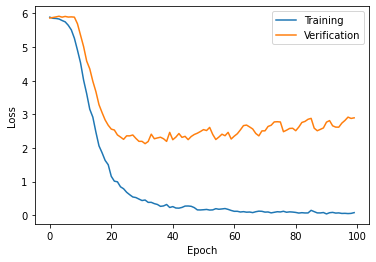

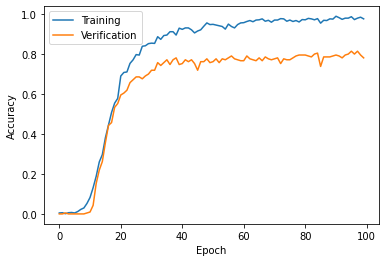

In [12]:
plot_loss(history)
plt.show()
plot_acc(history)
plt.show()

# 교차 검증

In [13]:
from sklearn.model_selection import StratifiedKFold, KFold

## train

In [14]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# cross validation
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# K-fold Cross Validation model evaluation
fold_no = 1

for train, test in kfold.split(train_X, train_Y):

  # Define the model architecture
  model = model

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(train_X[train], train_Y[train],
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=0)

  # Generate generalization metrics
  scores = model.evaluate(train_X[test], train_Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.001174612669274211; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.00613543251529336; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 3.0409453756874427e-05; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.002871729899197817; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.008002894930541515; accuracy of 99.40119981765747%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold

## test

In [15]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# cross validation
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# K-fold Cross Validation model evaluation
fold_no = 1

for train, test in kfold.split(test_X, test_Y):

  # Define the model architecture
  model = model

  # # Generate a print
  # print('------------------------------------------------------------------------')
  # print(f'Training for fold {fold_no} ...')

  # # Fit data to model
  # history = model.fit(X_train[train], Y_train[train],
  #                     batch_size=batch_size,
  #                     epochs=epochs,
  #                     verbose=0)

  # Generate generalization metrics
  scores = model.evaluate(test_X[test], test_Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Score for fold 1: loss of 4.415487766265869; accuracy of 80.95238208770752%
Score for fold 2: loss of 4.874973773956299; accuracy of 73.8095223903656%
Score for fold 3: loss of 1.8489844799041748; accuracy of 80.95238208770752%
Score for fold 4: loss of 3.2976536750793457; accuracy of 80.95238208770752%
Score for fold 5: loss of 1.7444301843643188; accuracy of 83.33333134651184%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.415487766265869 - Accuracy: 80.95238208770752%
------------------------------------------------------------------------
> Fold 2 - Loss: 4.874973773956299 - Accuracy: 73.8095223903656%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.8489844799041748 - Accuracy: 80.95238208770752%
------------------------------------------------------------------------
> Fold 4 - Loss: 3.2976536750793457 - Ac

# 결과 제출

In [16]:
import csv

test_dir = './drive/MyDrive/02_face_test'
file_list = os.listdir(test_dir)

result = []

for file in file_list:
    name = file.split('.')[0]
    data = cv2.imread(test_dir+'/'+file, 0)
    data = cv2.resize(data, (W,H))
    data = np.asarray(data)
    data = data.reshape(-1,W,H,1)
    data = data / np.max(data)
    y = model.predict_classes(data)
    result.append([name, y])
  

with open('./drive/MyDrive/1871063_김서영_얼굴_1차_답안.csv', 'w', newline='') as f:
  write = csv.writer(f)
  write.writerow(['Image', 'Answer'])
  write.writerows(result)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
